In [ ]:
import pandas as pd
import numpy as np

from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats import power

## Сокращение дисперсии

Чем меньше дисперсия (а с ней и среднеквадратичное отклонение):
* Тем меньший размер выборки нужен для наблюдения фиксированного эффекта
* Тем более низкие эффекты можно замечать при том же размере выборки

### Увеличение объёма выборки

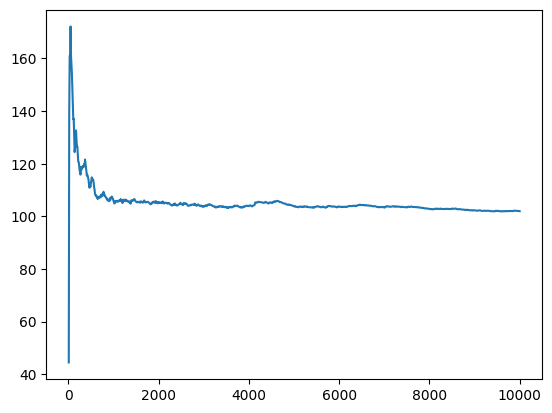

In [177]:
data = stats.norm.rvs(size=10000, loc=50, scale = 10)

size = 0
sizes = []
vars = []
while size < 10000:
    size += 10
    sizes.append(size)
    vars.append(np.var(data[:size]))

plt.plot(sizes, vars)
plt.show()

### Удаление наблюдений (тримминг)

Причины:
* Значительные выбросы
* Exposured-пользователи, то есть, пользователи из самого начала эксперимента. В тестовую группу могли попасть пользователи, не умеющие работать с тестируемой фичой, они вносят дополнительную дисперсию.

Но нужно убедиться в том, что не удаляются важные для эксперимента наблюдения.

In [4]:
data = stats.norm.rvs(size=1000, loc=50, scale = 10)
[lower, upper] = np.percentile(data, [5, 95])
trimmed = data[(data > lower) & (data < upper)]
data.var(), trimmed.var()

(102.91913294303933, 63.3364655599925)

### Стратификация и пост-стратификация

Заранее или во время экспериментов пользователи разбиваются на k **страт** по дополнительным фичам (типу устройства, региону и т.п.).

In [122]:
adsmart_data = pd.read_csv("../data/ad_smart.csv")
adsmart_data = adsmart_data[(adsmart_data.yes == 1) | (adsmart_data.no == 1)].drop(columns=['no'])
adsmart_data

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0
...,...,...,...,...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0


In [123]:
adsmart_data.groupby(['experiment', 'platform_os', 'browser']).yes.agg(["sum", "count"])

sum  count
experiment platform_os browser                               
control    5           Chrome Mobile iOS             1      1
                       Mobile Safari                 3      9
                       Mobile Safari UI/WKWebView    0      3
           6           Chrome                        0      1
                       Chrome Mobile               144    324
                       Chrome Mobile WebView        18     47
                       Facebook                     53    112
                       Mobile Safari                 0      1
                       Samsung Internet             45     88
exposed    5           Mobile Safari                 1      4
           6           Chrome                        1      1
                       Chrome Mobile               170    371
                       Chrome Mobile WebView        98    180
                       Facebook                     16     44
                       Samsung Internet             22     57

В каждой страте считается взвешенная оценка дисперсии: 
* $var_{strat}(Ŷ_{strat})=\frac{1}{n}\sum_{i=1}^{k}p_i \sigma_i^2$
* $p_i$ — вероятность попадания в страту (вес)
* $\sigma_i^2$ — дисперсия по страте.<br>

In [124]:
A = adsmart_data[adsmart_data.experiment == 'control'].drop(columns=['experiment'])

def weight(x):
    return len(x) / len(A)

A_strats = A.groupby(['platform_os', 'browser']).yes.agg(["sum", "count", "mean", "var", weight])
A_strats['strat_var'] = (A_strats['var'] * A_strats['weight']).fillna(0)
A_strats

sum  count      mean       var  \
platform_os browser                                                      
5           Chrome Mobile iOS             1      1  1.000000       NaN   
            Mobile Safari                 3      9  0.333333  0.250000   
            Mobile Safari UI/WKWebView    0      3  0.000000  0.000000   
6           Chrome                        0      1  0.000000       NaN   
            Chrome Mobile               144    324  0.444444  0.247678   
            Chrome Mobile WebView        18     47  0.382979  0.241443   
            Facebook                     53    112  0.473214  0.251528   
            Mobile Safari                 0      1  0.000000       NaN   
            Samsung Internet             45     88  0.511364  0.252743   

                                          weight  strat_var  
platform_os browser                                          
5           Chrome Mobile iOS           0.001706   0.000000  
            Mobile Safari               0.015358   0.003840  
            Mobile Safari UI/WKWebView  0.005119   0.000000  
6           Chrome                      0.001706   0.000000  
            Chrome Mobile               0.552901   0.136941  
            Chrome Mobile WebView       0.080205   0.019365  
            Facebook                    0.191126   0.048074  
            Mobile Safari               0.001706   0.000000  
            Samsung Internet            0.150171   0.037955

За счёт избавления от дисперсии между стратами суммарная дисперсия сокращается.

In [125]:
A.yes.var() - A_strats['strat_var'].sum()

0.001799941852853315

При этом среднее стратифицированное будет равно среднему по ГС:

$E(Ŷ_{strat})=\sum_{i=1}^{k}p_i E(Y_i) = E(Y) $

In [133]:
print('Mean:\t\t', A.yes.mean())
print('Strat mean:\t', (A_strats['mean'] * A_strats['weight']).sum())

Mean:		 0.45051194539249145
Strat mean:	 0.4505119453924915


Значит, не изменится и $lift$.

Плохо подобранные переменные для стратификации могут увеличить дисперсию:

In [127]:
bad_strats = 0
c = 20
for i in range(20):
    A['random_strats'] = np.random.randint(0, len(A_strats), size=len(A))
    random_groupped = A.groupby(['random_strats']).yes.agg(["var", weight])
    random_strat_var = (random_groupped['var'] * random_groupped['weight']).dropna().sum()
    A.drop(columns=['random_strats'])
    bad_strats += A.yes.var() - random_strat_var < 0
print('Разбиений на страты, увеличивших дисперсию: {}/{}'.format(bad_strats, c))

Разбиений на страты, увеличивших дисперсию: 12/20


Стратификация в A/B-тестировании:

In [128]:
B = adsmart_data[adsmart_data.experiment == 'exposed'].drop(columns=['experiment'])
B_strats = B.groupby(['platform_os', 'browser']).yes.agg(["sum", "count", "mean", "var", weight])
B_strats['strat_var'] = (B_strats['var'] * B_strats['weight']).fillna(0)
B_strats

sum  count      mean       var    weight  \
platform_os browser                                                           
5           Mobile Safari            1      4  0.250000  0.250000  0.006826   
6           Chrome                   1      1  1.000000       NaN  0.001706   
            Chrome Mobile          170    371  0.458221  0.248925  0.633106   
            Chrome Mobile WebView   98    180  0.544444  0.249410  0.307167   
            Facebook                16     44  0.363636  0.236786  0.075085   
            Samsung Internet        22     57  0.385965  0.241228  0.097270   

                                   strat_var  
platform_os browser                           
5           Mobile Safari           0.001706  
6           Chrome                  0.000000  
            Chrome Mobile           0.157596  
            Chrome Mobile WebView   0.076611  
            Facebook                0.017779  
            Samsung Internet        0.023464

Проверим, как изменится стандартное отклонение:

In [132]:
B_var = B_strats['strat_var'] / B_strats['count']
A_var = A_strats['strat_var'] / A_strats['count']
var_sums = B_var.add(A_var, fill_value=0)
counts = B_strats['count'].add(A_strats['count'], fill_value=0)
strat_portions = counts / (len(A) + len(B))
print('Std:\t\t', np.sqrt(B.yes.var()/len(B) + A.yes.var()/len(A)))
print('Std strat:\t', (var_sums * strat_portions).sum())

Std:		 0.028333326913229238
Std strat:	 0.0008386432369930233


## CUPED — Controlled-experiment Using Pre-Experiment Data

Этот метод сокращения дисперсии использует предэкспериментальные значения метрик.

$Y'_i = Y_i - (X_i - \mu_X) \Theta$

$Y' = \overline Y - (\overline X - \mu_X) \Theta$
* $Y$ — метрика во время проведения эксперимента
* $X$ — метрика до проведения эксперимента
* $\Theta = \frac{cov(X, Y)}{var(X)}$

In [183]:
# синтетические данные 
data = pd.read_csv("../data/commission_revenue.csv")
data

,group,user_id,commission_revenue_pre,commission_revenue_exp
0,control,cf7f6389-95e8-44b1-88d9-71a784d0eea3,126.174822,131.495757
1,control,6b129f09-fb5f-42df-bde3-a0daf9476c31,95.278575,105.803968
2,test,f5ce5d40-a918-482f-bd4a-27ade2af0d97,101.397369,101.787418
3,control,82592e1a-b6b7-42bf-a625-1fc138f92d3e,68.855613,56.851970
4,control,549b14a8-fc08-4224-bf8e-931a7a50e6ff,112.974435,101.960805
...,...,...,...,...
1995,test,074587da-a60a-4017-aa27-6d4c316efe71,80.804420,73.944887
1996,test,d1a843de-a1db-479f-9e23-65867cc57120,54.919574,79.652109
1997,test,c9e0f7e5-6c22-4434-9168-131e97841d9b,158.438671,141.914387
1998,control,c69dd04c-80c5-4c09-b961-ff188eb22a20,119.798094,101.634467


1/5. Посчитаем ковариацию по предэкспериментальному и экспериментальному периодам $cov(X, Y)$

In [184]:
A = data[data.group == 'control']
B = data[data.group == 'test']
A_cov = A['commission_revenue_pre'].cov(A['commission_revenue_exp'])
B_cov = B['commission_revenue_pre'].cov(B['commission_revenue_exp'])
A_cov, B_cov

(841.4528736624279, 891.1732687036978)

2/5. Найдём дисперсию $var(X)$<br>
3/5. И среднее по предэкспериментальному $\mu_X$

In [185]:
A_var_X = A['commission_revenue_pre'].var()
B_var_X = B['commission_revenue_pre'].var()
A_mean_X = A['commission_revenue_pre'].mean()
B_mean_X = B['commission_revenue_pre'].mean()

4/5. Используем формулу $Y'_i = Y_i - (X_i - \mu_X) \Theta$

In [187]:
A_theta = A_cov / A_var_X
B_theta = B_cov / B_var_X
A['corrected_exp'] = A['commission_revenue_exp'] - (A['commission_revenue_pre'] - A_mean_X) * A_theta
B['corrected_exp'] = B['commission_revenue_exp'] - (B['commission_revenue_pre'] - B_mean_X) * B_theta
A[['commission_revenue_exp', 'corrected_exp']]

,commission_revenue_exp,corrected_exp
0,131.495757,108.623411
1,105.803968,109.574804
3,56.851970,83.408480
4,101.960805,90.471729
5,106.796966,103.987132
...,...,...
1990,105.318220,100.594458
1991,107.706563,110.164456
1993,106.051609,130.934090
1994,120.714355,80.537567


Альтернативный расчёт $\Theta$ — с помощью линейной регрессии.

In [182]:
print('Regression theta:\t', smf.ols('commission_revenue_exp ~ commission_revenue_pre', data=A).fit().params[1])
print('cov/var theta:\t\t', A_theta)

Regression theta:	 0.8623436524590831
cov/var theta:		 0.862343652459082


Как будет выглядеть формула дисперсии:
$var(Y_{CUPED}) = var(\overline Y - \Theta \overline X) = \frac{1}{n}var(Y - \Theta X) = \frac{1}{n}[var(Y) + \Theta^2 var(X) - 2 \Theta cov(Y, X)]$

In [117]:
cuped_var = A['corrected_exp'].var() 
reg_var = A['commission_revenue_exp'].var()
print('Var:\t\t', reg_var)
print('Cuped var:\t', cuped_var)

Var:		 921.2513496526765
Cuped var:	 204.88700313832683


При $\Theta = \frac{cov(X, Y)}{var(X)}$ дисперсия минимизируется. Проверим:

$var(Y_{CUPED}) = \frac{1}{n}(var(Y) + \frac{cov^2(Y, X)}{var(X)} - 2 \frac{cov^2(Y, X)}{var(X)}) = \frac{1}{n}(var(Y) - \frac{cov^2(Y, X)}{var(X)}) =
\frac{1}{n}var(Y)(1 - \frac{cov^2(Y, X)}{var(X)var(Y)}) = var(\overline Y)(1 - cor^2(X, Y))$

$$\frac{var(Y_{CUPED})}{var(\overline Y)} = (1 - cor^2(X, Y))$$

In [188]:
cor = A['commission_revenue_pre'].corr(A['commission_revenue_exp'])
print('Var decrease:\t', cuped_var / reg_var)
print('1 - cor^2:\t', 1 - cor * cor)

Var decrease:	 0.2224007630659883
1 - cor^2:	 0.2201882010328382


Оценка CUPED **несмещенная** за счёт вычитания $\mu_X=E(X)$:
$$E(Y_{CUPED})=E(\overline Y -(\overline X - E(X))\Theta)=E(\overline Y) - \Theta E(\overline X) + \Theta E(X)=E(Y)$$

In [189]:
print('Mean:\t\t', A['corrected_exp'].mean())
print('Cuped mean:\t', A['commission_revenue_exp'].mean())

Mean:		 99.42347070906243
Cuped mean:	 99.23620725970872


5/5. Применяем стат.критерий к скорректированному $Y'$

In [163]:
print('P-val:\t\t', stats.ttest_ind(B['commission_revenue_exp'], A['commission_revenue_exp'], equal_var=False).pvalue)
print('CUPED p-val:\t', stats.ttest_ind(B['corrected_exp'].dropna(), A['corrected_exp'].dropna(), equal_var=False).pvalue)

P-val:		 0.07174908312970041
CUPED p-val:	 0.0003037261295519414


Сравнение необходимого количества экспериментов:

In [198]:
alpha = 0.05
beta = 0.8
lift = 0.05

effect_size = lift * A['commission_revenue_exp'].mean() / A['commission_revenue_exp'].std()
n = np.ceil(power.tt_ind_solve_power(effect_size=effect_size, ratio=1, power=beta, alpha=alpha))

cuped_effect_size = lift * A['corrected_exp'].mean() / A['corrected_exp'].std()
cuped_n = np.ceil(power.tt_ind_solve_power(effect_size=cuped_effect_size, ratio=1, power=beta, alpha=alpha))

print('Before CUPED:\t', n)
print('After CUPED:\t', cuped_n)

Before CUPED:	 589.0
After CUPED:	 132.0


Наглядно показали, что сокращение дисперсии полезно для уменьшения необходимого количества экспериментов.